Assignment2 - INFO284 - Daniel Bjørke(dbj001) & Jostein Standal(hib003)

**Preparing**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
import torchvision.transforms as transforms 

**Model** #This model is influenced by the code provided from DeepLizards guide on neural networks. https://deeplizard.com/learn/video/IKOHHItzukk

In [0]:
class Neural_Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
 
    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  def forward(self, tensor):
    tensor = self.conv1(tensor)
    tensor = F.relu(tensor)
    tensor = F.max_pool2d(tensor, kernel_size=2, stride=2) 

    tensor = self.conv2(tensor)
    tensor = F.relu(tensor)
    tensor = F.max_pool2d(tensor, kernel_size=2, stride=2) 

    tensor = tensor.reshape(-1, 12*4*4)
    tensor = self.fc1(tensor)
    tensor = F.relu(tensor)

    tensor = self.fc2(tensor)
    tensor = F.relu(tensor)

    tensor = self.out(tensor)
    
    return tensor

**Load training and testing data**

In [0]:
training_set = torchvision.datasets.FashionMNIST(
    root="./data/FashionMNIST",
    train = True, 
    download = True, 
    transform = transforms.Compose([transforms.ToTensor()]))

training_loader = torch.utils.data.DataLoader(training_set, batch_size = 50, shuffle=True)

testing_set = torchvision.datasets.MNIST(root='./data/FashionMNIST', 
  train=False, 
  download=True, 
  transform=transforms.Compose([transforms.ToTensor()]))

testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=50)

Extracting ./data/FashionMNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/MNIST/raw


Extracting ./data/FashionMNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/MNIST/raw




Extracting ./data/FashionMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/MNIST/raw


Extracting ./data/FashionMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/MNIST/raw
Processing...
Done!


**Running five epocs**

In [0]:
def get_num_correct(prediction, labels):
    return prediction.argmax(dim=1).eq(labels).sum().item()

In [0]:


network = Neural_Network()

batch_size = 10
lr = 0.001

training_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle=True)
optimizer = optim.Adam(network.parameters(), lr=lr)

for epoch in range(5):

  total_loss = 0
  correct_predictions = 0

  for batch in training_loader:
    images, correct_labels = batch

    prediction = network(images)
    loss = F.cross_entropy(prediction, correct_labels)

    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()

    total_loss += loss.item()
    correct_predictions += get_num_correct(prediction, correct_labels)

  print("epoch:", epoch+1, "| Correct predictions:", correct_predictions, "| Total loss:", round(total_loss, 2), "| Accuracy:",round(correct_predictions / len(training_set), 2), "| learning rate=", lr, "| batch_size", batch_size)

epoch: 1 | Correct predictions: 47543 | Total loss: 3297.12 | Accuracy: 0.79 | learning rate= 0.001 | batch_size 10
epoch: 2 | Correct predictions: 52107 | Total loss: 2141.07 | Accuracy: 0.87 | learning rate= 0.001 | batch_size 10
epoch: 3 | Correct predictions: 53109 | Total loss: 1858.15 | Accuracy: 0.89 | learning rate= 0.001 | batch_size 10
epoch: 4 | Correct predictions: 53702 | Total loss: 1701.5 | Accuracy: 0.9 | learning rate= 0.001 | batch_size 10
epoch: 5 | Correct predictions: 54001 | Total loss: 1606.8 | Accuracy: 0.9 | learning rate= 0.001 | batch_size 10


In [0]:
torch.save(network.state_dict(), 'network.pth')

In [9]:
network2 = Neural_Network()
network2.load_state_dict(torch.load("network.pth"))

<All keys matched successfully>

Confusion matrix, without normalization
[[5573    1  121   63    7    2  184    0   49    0]
 [  19 5847    0   93   14    3   12    0   12    0]
 [  63    0 5218   42  517    0  146    0   14    0]
 [ 252    5   36 5328  274    3   72    0   30    0]
 [  13    1  290  110 5454    0  116    0   16    0]
 [   0    0    0    0    0 5965    0   14   11   10]
 [1172    1  572   86  688    1 3437    0   43    0]
 [   0    0    0    0    0  374    0 5561   18   47]
 [  15    0   10    6   17    1   17    0 5934    0]
 [   0    0    0    0    0  124    0  358    4 5514]]


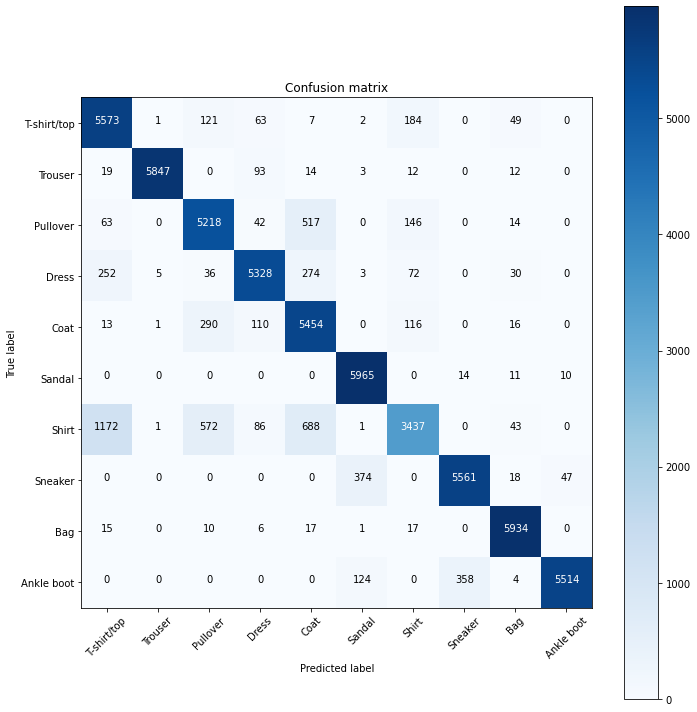

In [28]:
#Reused the code from https://deeplizard.com/learn/video/0LhiS6yu2qQ to make the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(training_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

preds_correct = get_num_correct(train_preds, training_set.targets)

stacked = torch.stack(
    (
        training_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

cmt = torch.zeros(10,10, dtype=torch.int64)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cm = confusion_matrix(training_set.targets, train_preds.argmax(dim=1))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
  
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)